In [1]:

import os
import pandas as pd
import numpy as np
import csv
import requests
from bs4 import BeautifulSoup 
import re
import undetected_chromedriver as uc
import time
import fractions
import traceback
from ctypes import pythonapi
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt      
import math
import seaborn as sns

%matplotlib inline

# form pythonapi.display import display

from plotnine import *
from plotnine import ggplot
from collections import Counter
from sklearn.decomposition import PCA
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from fractions import Fraction


In [2]:

url = "https://www.udemy.com/courses/development/data-science/?p=1"
url_format = "https://www.udemy.com/courses/development/data-science/?p={0}"
url_base = "https://www.udemy.com"

columns_list=['course name',
              'Link to course',
              'Number of students who purchased the course',
              'The number of students who rated the course',
              'The number of factors that took part in the creation of the course',
              'Last updated date',
              'the language of the course',
              'The number of languages into which the course is translated',
              'The number of languages for which the course has subtitles',
              'price',
              'Is the course on sale?',
              'The number of episodes',
              'Number of lectures in the course',
              'Duration of each lecture',
              'The name of the first lecturer',
              'Number of followers of the first lecturer',
              'The course number of the first lecturer',
              'Average rating of all courses of the first lecturer',
              'The name of the second lecturer',
              'Number of followers of the second lecturer',
              'The course number of the second lecturer',
              'Average rating of all courses of the second lecturer',
              'Does the course contain exercises?',
              'Does the course contain exams?',
              'Does the course contain a final exam?',
              'Course rating']
              #   'Difficulty level classification of the course',

In [ ]:
# bs4 is not supporting dinamic data loading, so I had to use selenium web driver 
# to get the linked javascript to the html's.
#browser.get(url)
# driver = webdriver.Chrome(executable_path = "c:\selenium browser drivers\chromedriver.exe")
browser = uc.Chrome()

In [3]:
#the function returns the number of pages in the courses section. 
def pages_amount():
    browser.get(url)
    time.sleep(2)
    html=browser.page_source
    soup=BeautifulSoup(html,"html.parser")
    info=soup.find("span", {"class": "ud-heading-sm pagination--page--13HGb"})
    pages=info.text
    return pages

In [4]:
def insert_link_to_list(html_udemy_page):
    browser.get(html_udemy_page)
    time.sleep(4)
    html_udemy_page=browser.page_source
    soup=BeautifulSoup(html_udemy_page,"html.parser")
    #print(soup)
    link = list()

    mtag = soup.find("div",attrs={"class":"course-list--container--FuG0T"})#--3zXPS
    #print(mtag)
    for card in mtag.find_all("a"):
         if card.findParent('h3',attrs={"data-purpose":"course-title-url"}):
            link.append(card['href'])
            print(card['href'])

    return link

In [5]:
def get_url_for_each_page(pages_count):
    all_courses_links=[]
    for i in range(1,pages_count+1):
        curr_url=url_format.format(i)
        all_courses_links.extend(insert_link_to_list(curr_url)) #appending all lists together from each page
    return all_courses_links

In [6]:
def create_df_to_links_course():
     num = pages_amount()
     print(num)
     links = list()
     links=get_url_for_each_page(int(num))
     df = pd.DataFrame({"links":links})
     print(df) #delete 
     return df

In [7]:
def get_details_from_single_item(item_link):
    browser.get(item_link)
    time.sleep(2)
    html=browser.page_source
    soup=BeautifulSoup(html)
    
    
    #course name
    name = soup.find("h1",{"class": "ud-heading-xl clp-lead__title clp-lead__title--small"})
    name_value = name.string
    
    #Number of students who purchased the course
    Number_purchased = soup.find("div",{"class": "enrollment"})
    Number_purchased_value = Number_purchased.string.split()[0] #clear text

    #The number of students who rated the course
    try:
        Number_rated = soup.find("a",{"class": "styles--rating-wrapper--ajCRv"})
        Number_rated = Number_rated.find_all('span')[-1]
        Number_rated_value = Number_rated.string.split()[0][1:] #clear text
    except Exception as e:
        Number_rated = soup.find("div",{"class": "styles--rating-wrapper--ajCRv"})
        Number_rated = Number_rated.find_all('span')[-1]
        Number_rated_value = Number_rated.string.split()[0][1:] #clear text
    #print(Number_rated_value)
    
    #The number of factors that took part in the creation of the course
    number_of_factors_creation =       soup.find("span",{"class": "instructor-links--names--3U_NU"})
    number_of_factors_creation =       number_of_factors_creation.find_all('a')
    number_of_factors_creation_value = len(number_of_factors_creation)
    

    #Last updated date
    try:
        last_update_date =       soup.find("div",{"class": "last-update-date"})
        last_update_date =       last_update_date.find('span')
        last_update_date_value = last_update_date.string.split()[2] #clear text
    except Exception as e:
        last_update_date_value = "null"

    #the language of the course
    try:
        language =       soup.find("div",{"class": "clp-lead__element-item clp-lead__locale"})
        language_value = language.text
    except Exception as e:
        language = "null"

    #The number of languages into which the course is translated
    language_translated =       soup.find("div",{"class": "clp-lead__element-item clp-lead__locale"})
    language_translated_value = len(language_translated.text.split())

    #The number of languages for which the course has subtitles
    try:
        language_subtitles =       soup.find("div",{"class": "ud-text-sm caption--captions--joQAG"})
        num1 =       language_subtitles.find_all('span')
        if(len(num1)> 1):
            language_subtitles_value = int(len(num1[0].text.split())/2) + int(num1[-1].text.split()[0])
          #  print("text1")
        else:
            language_subtitles_value = 1
    except Exception as e:
        language_subtitles_value = 0

    #Is the course on sale?
    try:
        is_sale   = soup.find_all("div",{"class":"price-text--price-part--2npPm price-text--original-price--1sDdx ud-clp-list-price ud-text-sm"})[-1]
        is_sale_value = 1
    except Exception as e:
        is_sale_value = 0
   
    #price 
    #price
    if is_sale_value == 1:
        price  =  soup.find_all("div",{"data-purpose": "course-old-price-text"})[1]
        try:
            price_value = price.find_all('span')[-1].string[1:]
        except Exception as e:
            price_value = "null"
    else:# sale_value == 0 -> no sale
        try:
            price = soup.find_all('div',{"class":"buy-box--buy-box-item--2RETv"})[1]
            price = price.find_all('span')[-1].string
            if price == "Free":
                price_value = 0
            else:
                price_value =price.string[1:]
        except Exception as e:
            price_value = "null"


    #The number of episodes
    try:
        episodes = soup.find("div",{"data-purpose":"course-curriculum"})
        if episodes is not None:
            try:
                episodes = episodes.find('span',{"class":"curriculum--content-length--5Nict"})
                num_of_episodes = episodes.text.split()[0]
            except Exception as e:
                num_of_episodes = "null"
                traceback.print_exc()
        else:
            try:
                episodes = soup.find("span",{"class":"curriculum--content-length--5Nict"})
                num_of_episodes = episodes.text.split()[0]
            except Exception as e:
                traceback.print_exc()
                num_of_episodes = "null"
    except Exception as e:
        num_of_episodes = "nulll"

    # #Number of lectures in the course
    try:
        num_of_lectures = episodes.text.split()[3]
    except Exception as e:
        num_of_lectures = "null"

    # #time of lectures in the course
    try:
        time_of_lectures = episodes.text.split()[6] +' '+ episodes.text.split()[7] #clear text
    except Exception as e:
        time_of_lectures = "null"

    #The info of the first lecturer
   # print("test 5")
    all_lucturers = soup.find("div",{"class": "component-margin styles--instructors--1dmIT"})
    all_lucturers = all_lucturers.find_all("div",{"class": "instructor--instructor--2sjZy"})
    
    first_lucturer = all_lucturers[0]
  #  print("test 6 first lecturer")
    first_lecturer_name = first_lucturer.find("a").text
    first_lucturer = first_lucturer.find_all("li")
    first_lecturer_student = first_lucturer[2].text.split()[0]
    first_lecturer_courses = first_lucturer[3].text.split()[0]
    first_lecturer_rating  = first_lucturer[0].text.split()[0]

    #The info of the secound lecturer
    if(number_of_factors_creation_value > 1):
        secound_lucturer = all_lucturers[1]
       # print("test 7 second lecturer")
        secound_lecturer_name = secound_lucturer.find("a").text
        secound_lucturer = secound_lucturer.find_all("li")
        secound_lecturer_student = secound_lucturer[2].text.split()[0]
        secound_lecturer_courses = secound_lucturer[3].text.split()[0]
        secound_lecturer_rating  = secound_lucturer[0].text.split()[0]
    else:
        secound_lecturer_name = 'null'
        secound_lecturer_student = 'null'
        secound_lecturer_courses = 'null'
        secound_lecturer_rating = 'null'

    #Does the course contain exercises?
   # print("test 8 description")
    try:
        describe_course = soup.find("div",{"class": "incentives--incentives-container--1QKGj"})
        if (describe_course.find("span",{"data-purpose":"num-coding-exercises"})) is not None:
            exercises = 1
        else:
            exercises = 0
    except Exception as e:
        exercises = 0    
    #Does the course contain quiz?
 #   print(" test 9 quiz ")
    try:
        describe_course1 = soup.find("div",{"data-purpose":"course-curriculum"})
        if (describe_course1.find("use",{"xlink:href":"#icon-quiz"})) is not None:
            quiz = 1
        else:
            quiz = 0
    except Exception as e:
        quiz=0

    #Does the course contain a final exam?
   # print("test 10 practices")
    describe_course2 = soup.find("span",{"data-purpose":"num-practice-tests"})
    if (describe_course2) is not None:
        final_test = 1
    else:
        final_test = 0
    
    #Course rating
    try:
        rating = soup.find("span",{"class":"ud-heading-sm star-rating--rating-number--3l80q"}).text
    except Exception as e:
      #  print("Rating Error")
        rating = 0

    line = {'course name':name_value,
            'Link to course':item_link,
            'Number of students who purchased the course':Number_purchased_value,
            'The number of students who rated the course':Number_rated_value,
            'The number of factors that took part in the creation of the course':number_of_factors_creation_value,
            'Last updated date':last_update_date_value,
            'the language of the course':language_value,
            'The number of languages into which the course is translated':language_translated_value,
            'The number of languages for which the course has subtitles':language_subtitles_value,
            'price':price_value,
            'Is the course on sale?':is_sale_value,
            'The number of episodes':num_of_episodes,
            'Number of lectures in the course':num_of_lectures,
            'Duration of each lecture':time_of_lectures,
            'The name of the first lecturer':first_lecturer_name,
            'Number of followers of the first lecturer':first_lecturer_student,
            'The course number of the first lecturer':first_lecturer_courses,
            'Average rating of all courses of the first lecturer':first_lecturer_rating,
            'The name of the second lecturer':secound_lecturer_name,
            'Number of followers of the second lecturer':secound_lecturer_student,
            'The course number of the second lecturer':secound_lecturer_courses,
            'Average rating of all courses of the second lecturer':secound_lecturer_rating,
            'Does the course contain exercises?':quiz,
            'Does the course contain exams?':exercises,
            'Does the course contain a final exam?':final_test,
            'Course rating':rating}
             #'Difficulty level classification of the course':,

    return line
  

In [8]:
def insert_details_to_dataframe(df_main,line):
    df_main=df_main.append( pd.Series(line), ignore_index=True)
    return( df_main)

In [9]:
def merge_dataframes(dataframe_list):
    df = dataframe_list[0]
    for i in range(1, len(dataframe_list)):
        df = pd.concat([df, dataframe_list[i]], axis=0, join='outer')
    return df

In [10]:
def create_main_df(df_main,df_links):
    num_of_rows = df_links.shape[0]
    del_list = list()
    df_delete_courses = pd.DataFrame({"name": del_list})
    for i in range(0,num_of_rows):
        url_course = url_base + df_links.iloc[i,1]
        try:
            item_dictionary=get_details_from_single_item(url_course)
            df_main=insert_details_to_dataframe(df_main,item_dictionary)
            if((i > 99) and ((i % 100) == 0)):
                df_main.to_csv("test_{0}.csv".format(i))##backup save
        except Exception as e:
            df_main.to_csv("test_{0}.csv".format(i-1))
            print(e)
            traceback.print_exc()
            print(url_course)
            del_list.append(url_course)##list of courses with errors
            df_delete_courses.to_csv("delete_list1.csv".format(i))##csv file for the problematic courses

    

    return (df_main)

In [11]:
def fix_null_values(df_main,df_links):
    num_of_rows = df_links.shape[0]
    for link in df_links:
        #url_course =df_links.iloc[i,0]
        try:
            item_dictionary=get_details_from_single_item(link)
            df_main=insert_details_to_dataframe(df_main,item_dictionary)
           
        except Exception as e:
            print(e)
            traceback.print_exc()
            print(link)
  

    return (df_main)

In [ ]:
#Future main block - generates links of courses, main data of each course
df_links_to_courses = pd.DataFrame()
#df_links_to_courses = create_df_to_links_course()
#df_links_to_courses.to_csv("links_to_courses.csv")
df_links_to_courses = pd.read_csv("links_to_courses.csv")
df_main = pd.DataFrame()
df_main = create_main_df(df_main,df_links_to_courses)
df_main.to_csv('check.csv')





In [ ]:
# This cell is another part of main - serves to make order with the csv files and merge them all together
df_1 = pd.read_csv("test_1000.csv") #0-999
df_2 = pd.read_csv("test_1723.csv")#1000-1722
df_3 = pd.read_csv("test_2498.csv")#1723-2497
df_4 = pd.read_csv("check.csv")#3000-end
list_df = [df_1,df_2,df_3,df_4]
total_df = merge_dataframes(list_df)
total_df = total_df.drop_duplicates()
total_df.drop('Unnamed: 0',axis=1,inplace=True)
total_df = total_df.reset_index(drop=True)
total_df.to_csv('total_df.csv')

In [12]:
#Function that catches the null values and sorts them into a list of links in order to crawl again 
def second_crawl_for_false_null_values(df_main):
    df_copy = df_main.copy()
    df_main = df_main.dropna(subset=['The number of episodes', 'Number of lectures in the course', 'Duration of each lecture'])
    df_copy = df_copy.loc[(df_copy['The number of episodes'].isnull())| (df_copy['Number of lectures in the course'].isnull()) | (df_copy['Duration of each lecture'].isnull())] 
    links_to_courses = pd.DataFrame()
    links_to_courses = df_copy['Link to course']
    links_to_courses = links_to_courses.reset_index(drop=True)
    return links_to_courses

In [ ]:
new_list_to_course = pd.DataFrame()
new_list_to_course = second_crawl_for_false_null_values(total_df)
# final_df.to_csv('final_df.csv')
final_df = fix_null_values(total_df,new_list_to_course)
final_df = final_df.reset_index(drop=True)
final_df.to_csv('final_df.csv')

In [13]:
def convert_duration_to_float(duration_str):
    if 'h' in duration_str:
        hours, minutes = duration_str.split('h ')
        if int(hours) == 0:
            return float(minutes.replace('m',''))/60
        else:
            return float(hours) + float(minutes.replace('m',''))/60
    else:
        return float(duration_str.replace('m total', ''))/60


In [14]:
def replace_missing_values(df2):
    df = df2.copy()



    # col 6 Last_updated_date - fills the null values with the most common date
    most_common = df['Last updated date'].mode().iloc[0]
    df['Last updated date'].fillna(most_common, inplace=True)

    # cols 11,12,13 - drops the rows with null values after second_crawl_for_false_null_values function result
    df.dropna(subset=['The number of episodes', 'Number of lectures in the course', 'Duration of each lecture'],inplace=True)

    #col 13 - Duration_of_lectures - converts the default value to real number
    df['Duration of each lecture'] = df['Duration of each lecture'].apply(convert_duration_to_float)

    #cols 2,3,15,16,19 - converts the following columns from string to numeric values.
    cols = ['Number of students who purchased the course',
            'The number of students who rated the course',
            'Number of followers of the first lecturer',
            'The course number of the first lecturer',
            'Number of followers of the second lecturer']
    for col in cols:
        df[col] = pd.to_numeric(df[col].replace({',':'','--':''},regex=True))


    #col 17 - Average_rating_of_all_courses_of_the_first_lecturer - 
    # converts the string values to numeric values + fills with median value the empty cells
    df['Average rating of all courses of the first lecturer'] = pd.to_numeric(df['Average rating of all courses of the first lecturer'].str.replace('--',''))
    col_numery = {'Average rating of all courses of the first lecturer':df["Average rating of all courses of the first lecturer"].median()}
    df=df.fillna(col_numery)
    
    #col 18 - The_name_of_the_second_lecturer - converts into boolean value
    df['The name of the second lecturer'] = df['The name of the second lecturer'].notnull().astype(int)

    #col 19,20,21 - fills the following columns with '0' value if cell is empty (the columns are represented by boolean value)
    col_secound = {'Number of followers of the second lecturer':0 ,
                'The course number of the second lecturer':0, 
                'Average rating of all courses of the second lecturer':0,
                'Number of followers of the first lecturer':0}
    df = df.fillna(col_secound)




    return df

In [ ]:
final_df = pd.read_csv("final_df.csv")

In [ ]:
try:
    clean_df = replace_missing_values(final_df)
    clean_df.drop('Unnamed: 0',axis=1,inplace=True)
    clean_df = clean_df.reset_index(drop=True)
    clean_df.to_csv('clean.csv')
except Exception as e:
    traceback.print_exc()


In [ ]:
#Columns for normalizing : Number of students who purchased the course,
#                          The number of students who rated the course,
#                          price,
#                          The number of languages for which the course has subtitles,
#                          The number of episodes
#                          Number of lectures in the course
#                          Duration of each lecture
#                          Number of followers of the first lecturer
#                          The course number of the first lecturer
#                          Average rating of all courses of the first lecturer
#                          Number of followers of the second lecturer
#                          The course number of the second lecturer
#                          Average rating of all courses of the second lecturer
#                          Course rating







In [15]:
df = pd.read_csv("clean.csv")
dataset=df.copy()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 27 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Unnamed: 0                                                          3029 non-null   int64  
 1   course name                                                         3029 non-null   object 
 2   Link to course                                                      3029 non-null   object 
 3   Number of students who purchased the course                         3029 non-null   int64  
 4   The number of students who rated the course                         3029 non-null   int64  
 5   The number of factors that took part in the creation of the course  3029 non-null   int64  
 6   Last updated date                                                   3029 non-null   object 
 7   the language of

<Axes: xlabel='Course rating'>

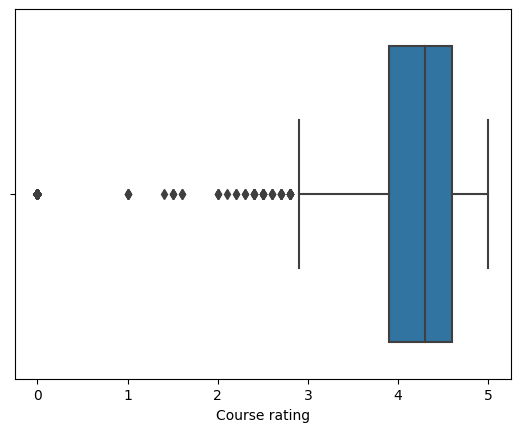

In [16]:
sns.boxplot(x=dataset["Course rating"], orient='horizontal')

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 27 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Unnamed: 0                                                          3029 non-null   int64  
 1   course name                                                         3029 non-null   object 
 2   Link to course                                                      3029 non-null   object 
 3   Number of students who purchased the course                         3029 non-null   int64  
 4   The number of students who rated the course                         3029 non-null   int64  
 5   The number of factors that took part in the creation of the course  3029 non-null   int64  
 6   Last updated date                                                   3029 non-null   object 
 7   the language of

Noticable outliers are the 'Free' courses. 

<Axes: xlabel='Course rating'>

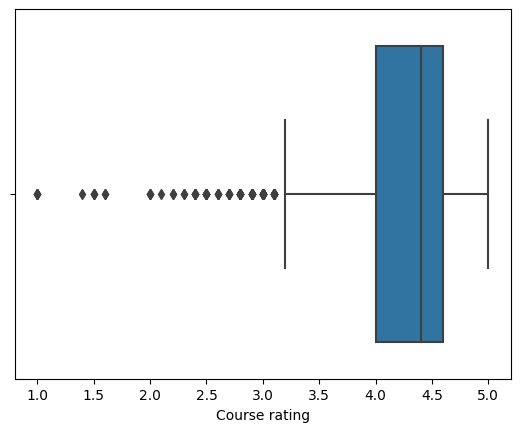

In [18]:
#Clearing the Free courses from the table.
dataset[(dataset['Course rating']==0)] = np.nan
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)

#Lets see the difference
sns.boxplot(x=dataset["Course rating"], orient='horizontal')


There are still noticable outliers, but they are crucial data for us.

In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 27 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Unnamed: 0                                                          2822 non-null   float64
 1   course name                                                         2822 non-null   object 
 2   Link to course                                                      2822 non-null   object 
 3   Number of students who purchased the course                         2822 non-null   float64
 4   The number of students who rated the course                         2822 non-null   float64
 5   The number of factors that took part in the creation of the course  2822 non-null   float64
 6   Last updated date                                                   2822 non-null   object 
 7   the language of

0.11665053856978963

<Figure size 5000x2000 with 0 Axes>

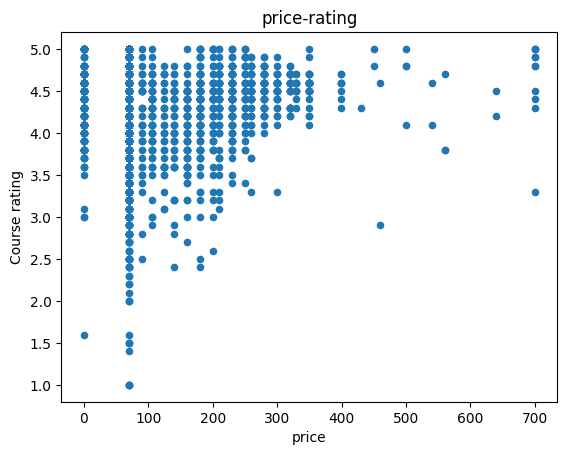

In [20]:
#Price X Rating 
fig = plt.figure(figsize=(50,20))
dataset.loc[:,['Course rating','price']].plot(title='price-rating',x='price',y='Course rating',kind='scatter')
#Correlation value:
dataset['price'].corr(dataset['Course rating'])

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 27 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Unnamed: 0                                                          2822 non-null   float64
 1   course name                                                         2822 non-null   object 
 2   Link to course                                                      2822 non-null   object 
 3   Number of students who purchased the course                         2822 non-null   float64
 4   The number of students who rated the course                         2822 non-null   float64
 5   The number of factors that took part in the creation of the course  2822 non-null   float64
 6   Last updated date                                                   2822 non-null   object 
 7   the language of

It is apparent that the correlation between price and Course rating is pretty weak, we will try to handle the data and remove outliers just in case

0.16488831415822058

<Figure size 5000x2000 with 0 Axes>

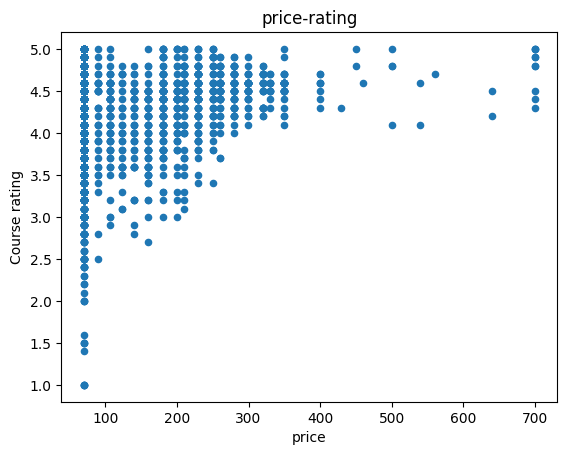

In [22]:
index_to_remove=[]
index_to_remove.append(dataset.query('(`Course rating` < 3.5 ) & (price > 250)|(`Course rating` < 4.0) & (price > 401)|(`Course rating` < 2.7) & (price > 101)| (price == 0)').index)
dataset.drop(index=index_to_remove[0].values,inplace=True)
dataset.reset_index(inplace=True,drop=True)

fig = plt.figure(figsize=(50,20))
dataset.loc[:,['Course rating','price']].plot(title='price-rating',x='price',y='Course rating',kind='scatter')

dataset['price'].corr(dataset['Course rating'])

In [23]:
dataset = dataset.dropna()

In [24]:
dataset['price'].describe()

count    2608.000000
mean      119.338650
std        88.978437
min        69.900000
25%        69.900000
50%        69.900000
75%       159.900000
max       699.900000
Name: price, dtype: float64

  price_binned      mean
0            1  4.223662
1            2  4.177099
2            3  4.450298
3            4  4.541975
4            5  4.656522


<Axes: xlabel='price_binned'>

<Figure size 2000x1000 with 0 Axes>

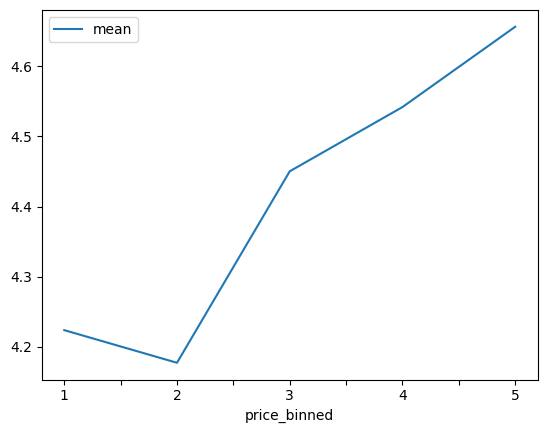

In [25]:
#Define bins and labels for further data handling
bins = [1,100,200,300,400,700]
labels =  [1,2,3,4,5]
dataset['price_binned'] = pd.cut(x = dataset['price'], bins = bins, labels = labels, include_lowest = True)
dataset.drop('price',inplace=True,axis=1)
prices=dataset['price_binned'].value_counts().keys()
##calculate the mean of course ratings
price_mean=[]
for price in prices:
    price_mean.append(dataset.loc[dataset['price_binned'] == price,['Course rating']].mean().values[0])
df_price_mean=pd.DataFrame({'price_binned':prices,'mean':price_mean})
df_price_mean.sort_values(by='mean',ascending=False)
#shows the bins of prices and the correlation between price and ratings
print(df_price_mean)
fig = plt.figure(figsize=(20,10))
df_price_mean.sort_values(by='price_binned',ascending=True).plot(x='price_binned',kind='line')

We can notice that the group prices '5' - 300NIS to 400NIS is the most significant group in terms of course rating.

<Axes: xlabel='Average rating of all courses of the first lecturer'>

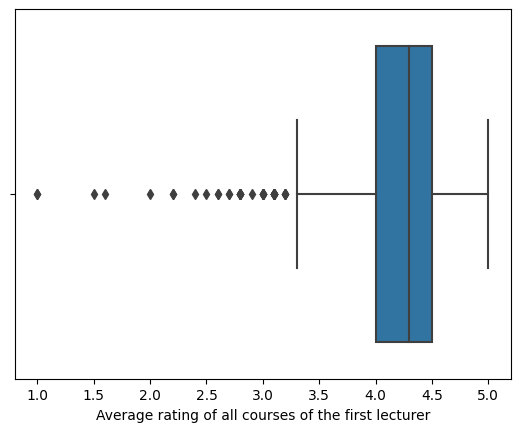

In [26]:
#Box plot representation of Number of students who purchased the course
sns.boxplot(x=dataset["Average rating of all courses of the first lecturer"], orient='horizontal')

0.7223734049326636

<Figure size 5000x2000 with 0 Axes>

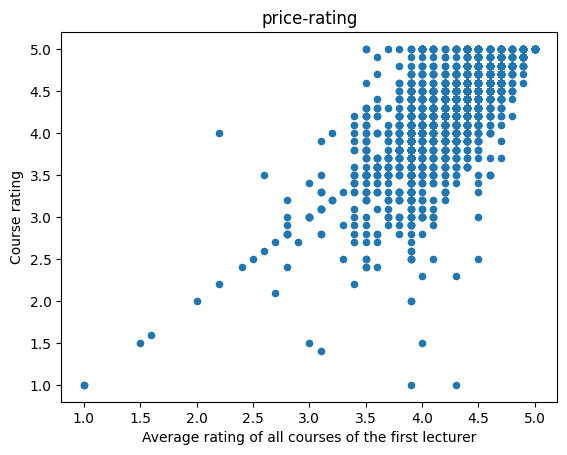

In [27]:
fig = plt.figure(figsize=(50,20))
dataset.loc[:,['Course rating','Average rating of all courses of the first lecturer']].plot(title='price-rating',x='Average rating of all courses of the first lecturer',y='Course rating',kind='scatter')

dataset['Average rating of all courses of the first lecturer'].corr(dataset['Course rating'])

Any manipulation in this data will affect the correlation for the worse, hence we decided to leave the outliers in the data. 

In [28]:
#Handling the language of the course data
data_dict = dataset['the language of the course'].value_counts().to_dict()



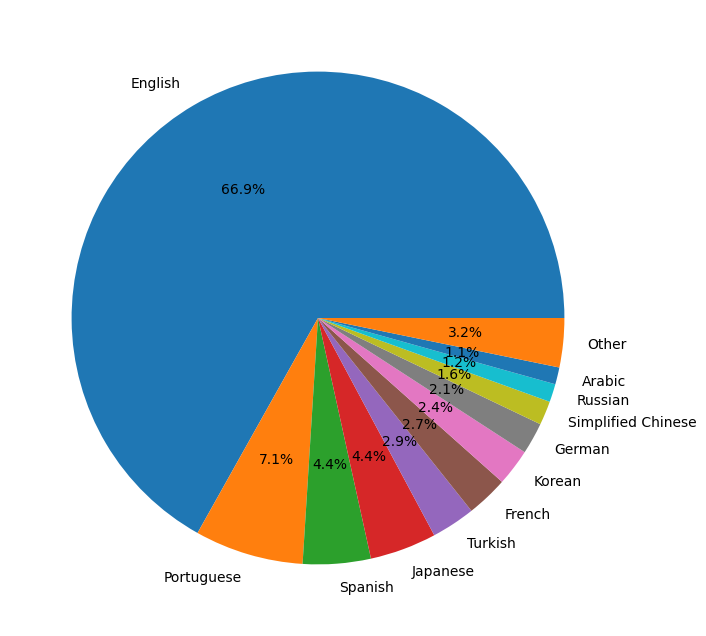

In [29]:
# merge the least common languages (under 1%) into a single category called "Other", there are 22 in total.
threshold = 24
other_count = sum(count for count in data_dict.values() if count < threshold)
data_dict = {k: v for k, v in data_dict.items()if v >= threshold}
data_dict['Other'] = other_count

# create a pie chart from the updated dictionary
plt.figure(figsize=(8, 8))
plt.pie(data_dict.values(), labels=data_dict.keys(),autopct='%1.1f%%')

# show the pie chart
plt.show()

The pie chart represents the distribution of the most common languages in the Data Science category 

In [30]:
# create a dictionary of the most common languages that are shown on the pie chart:
data_dict_table_language = data_dict.keys()
# create a list of values that are not in the data_dict
not_in_dict = list(set(dataset['the language of the course']) - set(data_dict_table_language))

# replace the values not in the data_dict with 'Other'
dataset.loc[dataset['the language of the course'].isin(not_in_dict), 'the language of the course'] = 'Other'


In [31]:

data_dict_table_language = list(data_dict.keys())
data_dict_table_count = [dataset['the language of the course'].value_counts()[language] for language in data_dict_table_language]

# create a list of the mean course ratings for each language
data_dict_table_mean_value = []
for language in data_dict_table_language:
    data_dict_table_mean_value.append(dataset.loc[dataset['the language of the course']==language, 'Course rating'].mean())

# create a DataFrame with the language name, count, and mean rating for each language
df_language_mean = pd.DataFrame({'language of the course': data_dict_table_language, 'Courses': data_dict_table_count, 'mean': data_dict_table_mean_value})

# sort the DataFrame by mean rating in descending order
df_language_mean = df_language_mean.sort_values(by='Courses', ascending=False)
df_language_mean


,language of the course,Courses,mean
0,English,1744,4.185665
1,Portuguese,186,4.565054
2,Spanish,116,4.339655
3,Japanese,114,4.147368
11,Other,84,4.466667
4,Turkish,75,4.418667
5,French,71,4.383099
6,Korean,63,4.741270
7,German,54,4.250000
8,Simplified Chinese,41,4.439024


In [32]:
#Now we will change the values of this category into numeric representation in order to try and salvage info which will support our project
value_counts = dataset['the language of the course'].value_counts()
classification_dict = {value: i+1 for i, value in enumerate(value_counts.index)}
for k,v in classification_dict.items():
    if v > 12 :
        classification_dict[k]=12
dataset['the language of the course'].replace(classification_dict, inplace=True)


<Axes: ylabel='Frequency'>

<Figure size 2000x1000 with 0 Axes>

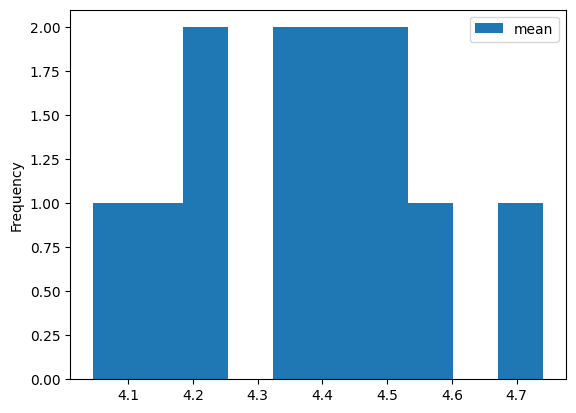

In [33]:
fig=plt.figure(figsize=(20,10))
df_language_mean.plot(x='language of the course',y='mean',kind='hist')


C:\Users\Tzik\AppData\Local\Temp\ipykernel_2820\2030484087.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

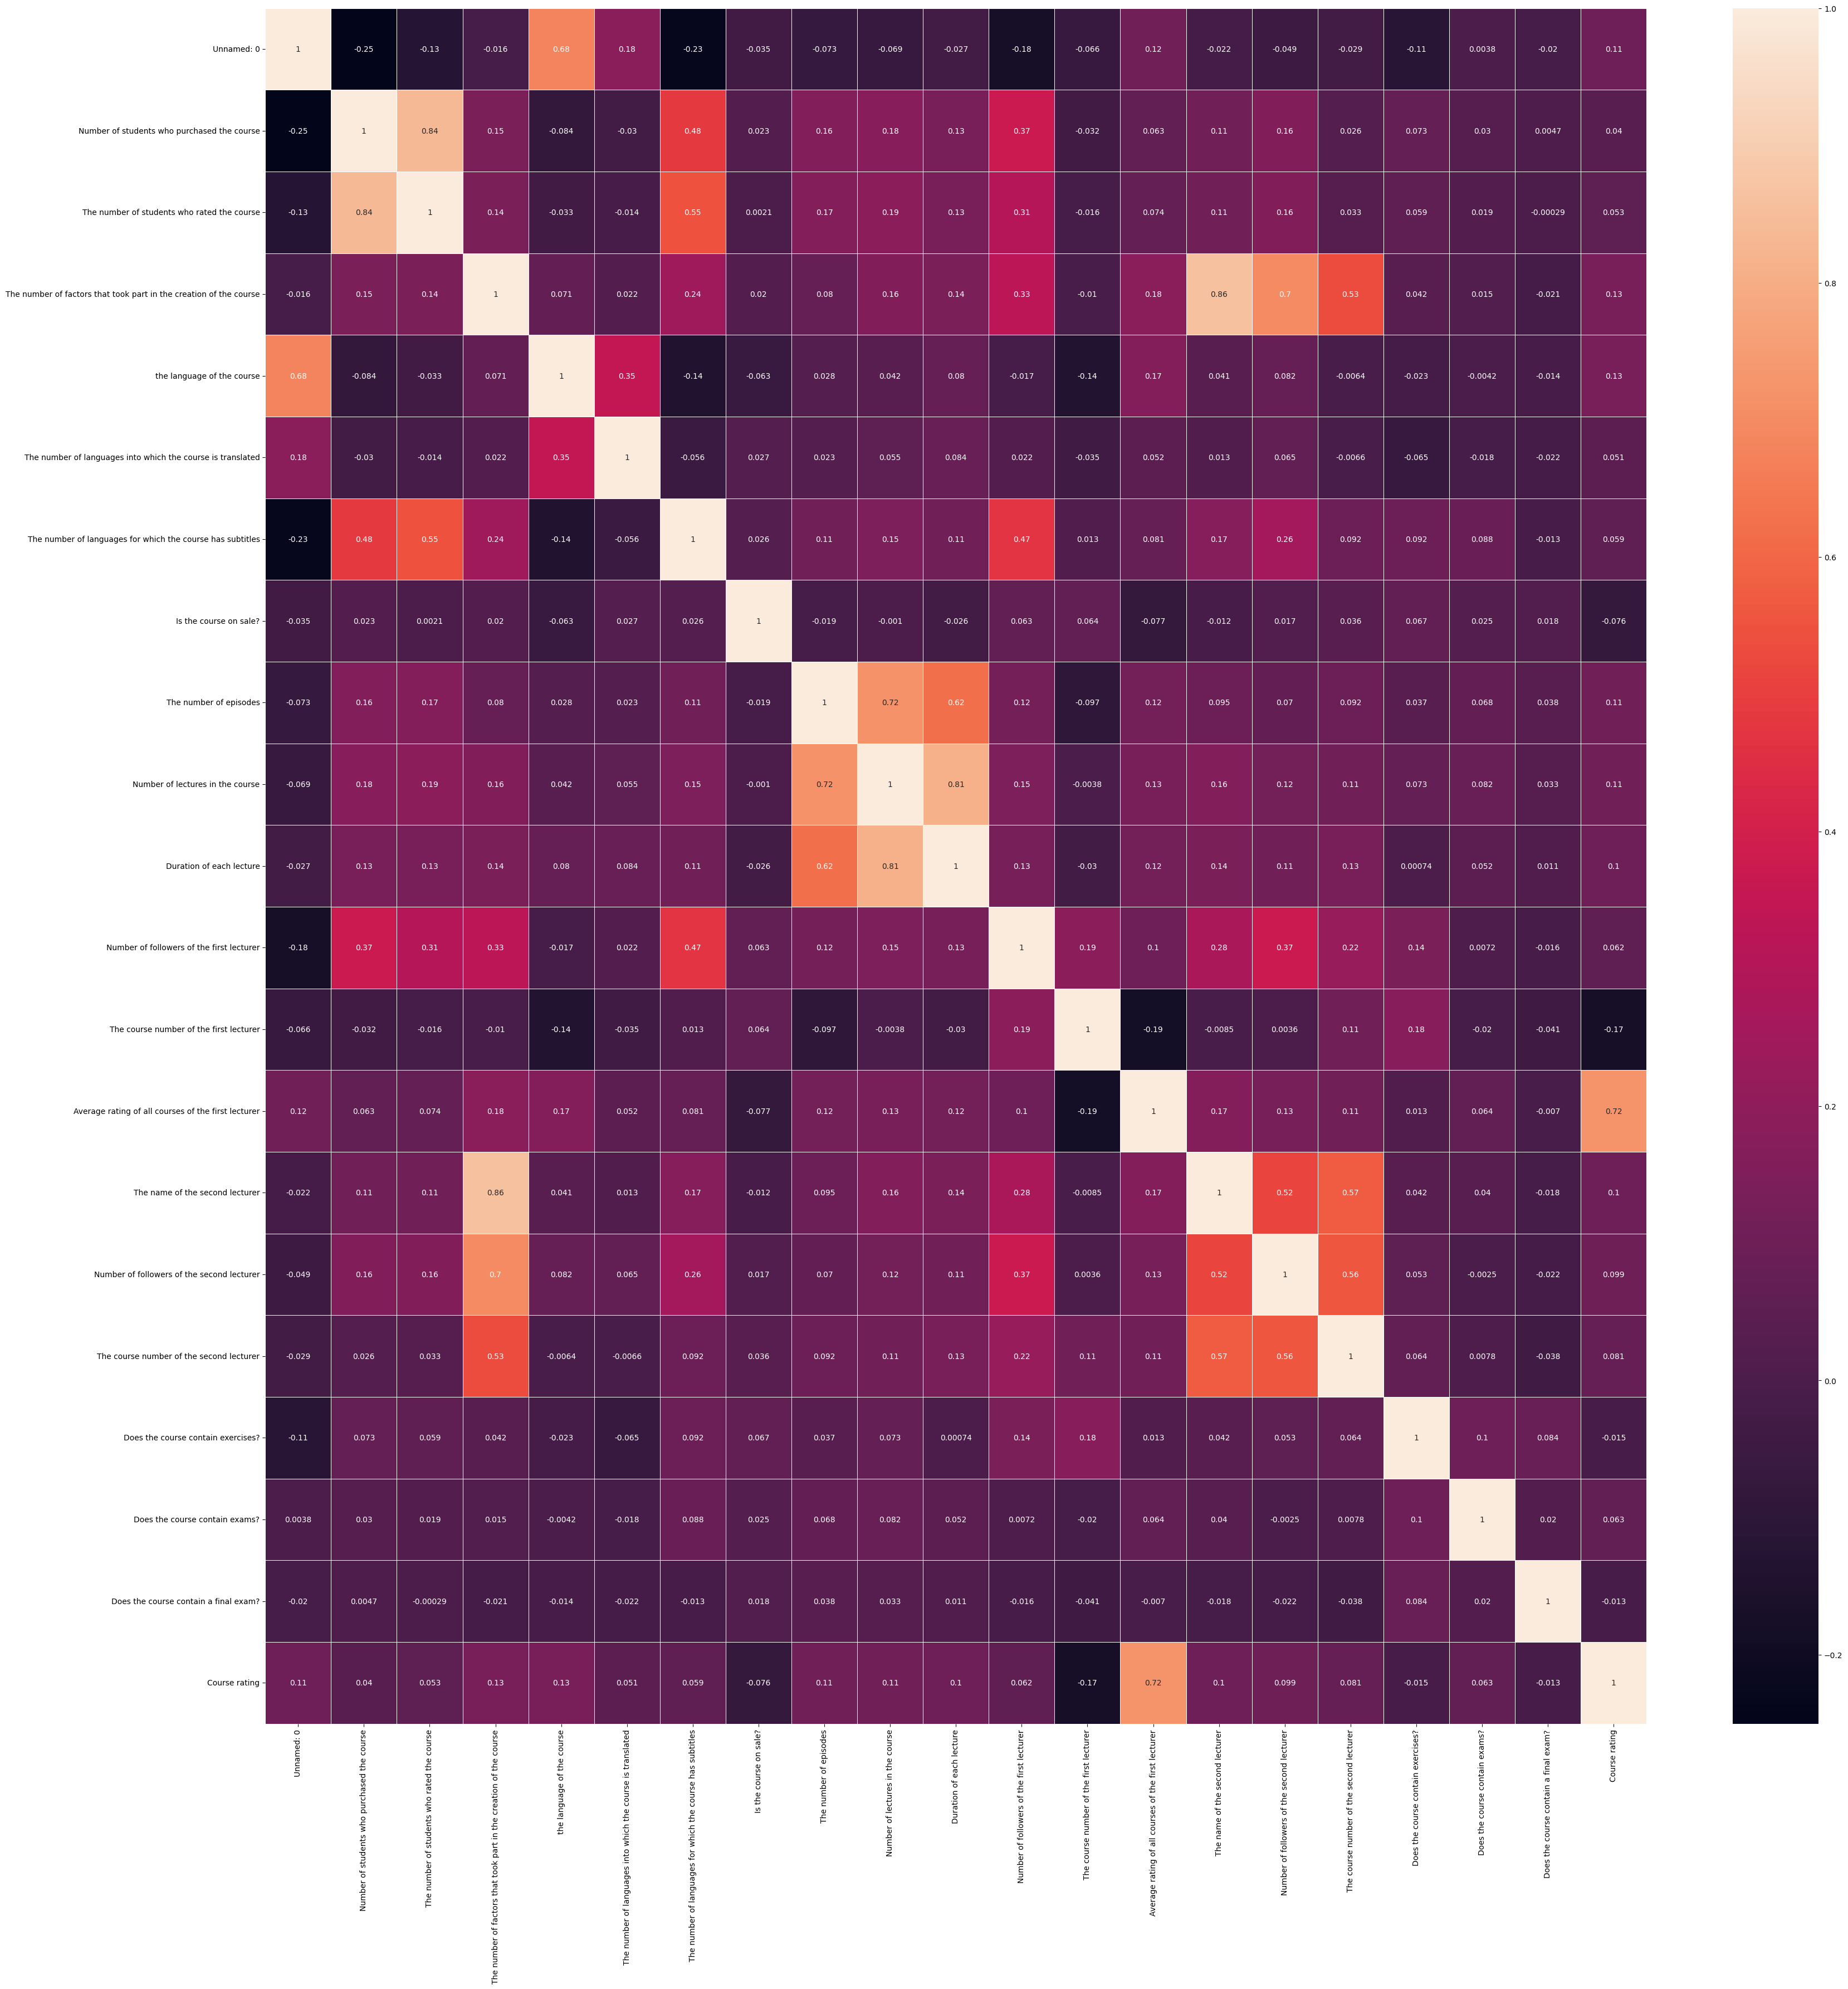

In [34]:
#sns.boxplot(x=dataset["price"], orient='horizontal')
corr=dataset.corr(method ='pearson')

fig, ax = plt.subplots(figsize=(40,40))         # Sample figsize in inches
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)


Machine Learning

In [35]:
dataset['Average rating of all courses of the second lecturer']=dataset['Average rating of all courses of the second lecturer'].astype(float)

data_corr = dataset[["Number of students who purchased the course",
                     "The number of students who rated the course",
                     "The number of factors that took part in the creation of the course",
                     "the language of the course",
                     "The number of languages into which the course is translated",
                     "The number of languages for which the course has subtitles",
                     "The course number of the first lecturer",
                     #"Average rating of all courses of the first lecturer",
                     "The name of the second lecturer",
                     "Number of followers of the second lecturer",
                     "The course number of the second lecturer",
                     "Average rating of all courses of the second lecturer",
                     "Does the course contain exercises?",
                     "Does the course contain exams?",
                     "Does the course contain a final exam?",
                     "price_binned",
                     "Course rating"]].copy()


In [36]:
TRAINING_FEATURES = data_corr.columns[data_corr.columns != 'Course rating']
TARGET_FEATURE    = 'Course rating'

X = data_corr[TRAINING_FEATURES]
y = data_corr[TARGET_FEATURE]

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model, model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

print("Initial amount of samples: #{}".format(X.shape[0]))
print("Number of training samples: #{}".format(X_train.shape[0]))
print("Number of test samples: #{}".format(X_test.shape[0]))


print("\nTarget distribution in original dataset:\n{}".format(y.value_counts()))
print("\nTarget distribution in the training set:\n{}\n".format(y_train.value_counts()))
print("Target distribution in the test set:\n{}".format(y_test.value_counts()))

Initial amount of samples: #2608
Number of training samples: #2086
Number of test samples: #522

Target distribution in original dataset:
4.5    262
4.6    256
4.4    235
4.7    222
4.3    185
5.0    171
4.2    166
4.1    145
4.8    141
4.0    116
3.9    116
3.8     98
4.9     86
3.7     76
3.6     71
3.5     63
3.3     36
3.2     32
3.0     29
3.4     24
2.8     13
3.1     13
2.9     12
2.5      9
2.7      6
2.4      5
1.0      4
2.6      3
2.0      3
1.5      3
2.2      2
2.3      2
2.1      1
1.6      1
1.4      1
Name: Course rating, dtype: int64

Target distribution in the training set:
4.5    214
4.6    205
4.4    187
4.7    178
4.3    149
5.0    131
4.2    128
4.8    118
4.1    117
4.0     97
3.9     97
3.8     77
4.9     72
3.7     60
3.6     55
3.5     51
3.3     28
3.2     26
3.0     21
3.4     19
3.1     10
2.9      9
2.8      9
2.5      7
2.4      5
2.7      3
1.0      3
1.5      2
2.6      2
2.2      2
1.6      1
2.0      1
1.4      1
2.3      1
Name: Course rating, dtype:

In [39]:
def scale_features(X_train, scale_type):
    if(scale_type == 'minmax'):
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_train_scaled = scaler.fit_transform(X_train)
        
    else:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
    return scaler, X_train_scaled

In [40]:
#Normalize function by standard or minmax (scaler parameter)
def scale_test_features(X_test, scaler):
    X_test = scaler.transform(X_test)
    return X_test

In [41]:
#Determine the type of ML for our model
linear_model =linear_model.LinearRegression()
#Building model 
linear_model.fit(X_train, y_train) 
#Making predictions to test the model on test data
y_pred_linear_model = linear_model.predict(X_test) 
#Assesment by RMSE metric of the accuracy between our model and the real values
print('Coefficients:', linear_model.coef_)
print('Intercept:', linear_model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_test, y_pred_linear_model))
print('Coefficient of determination (R^2): %.2f' % r2_score(y_test, y_pred_linear_model))

Coefficients: [-4.95513898e-07  3.52645362e-06  8.61937596e-02  2.03760242e-02
  1.09991069e-01  1.42777087e-03 -4.23909895e-04 -3.63346794e+00
 -8.51690393e-08  4.84682785e-04  8.27361798e-01 -1.73616882e-02
  2.44956250e-01  3.22367086e-02  8.29921626e-02]
Intercept: 3.8985962460486734
Mean squared error (MSE): 0.30
Coefficient of determination (R^2): 0.13


In [42]:
#Calculates the accuracy score of our model:
r2_score(y_test,y_pred_linear_model)

0.12517129806907723

In [43]:
#Normalizing by minmax values:
minmax_scaler, X_train_minmax_scaled = scale_features(X_train, 'minmax')
X_test_minmax_scaled = scale_test_features(X_test, minmax_scaler)
#Normazlizing by standard values:
standard_scaler, X_train_standard_scaled = scale_features(X_train, 'standard')
X_test_standard_scaled = scale_test_features(X_test, standard_scaler)

In [44]:
#Visualizing the mean values after the normalization process:
standard_scaler.mean_

array([7.39631208e+03, 5.48137105e+02, 1.28379674e+00, 2.48322148e+00,
       1.02109300e+00, 9.91850431e-01, 7.07852349e+01, 1.90795781e-01,
       1.06599662e+05, 1.37641419e+01, 8.39022052e-01, 2.90987536e-01,
       1.53403643e-02, 2.49280920e-02, 1.53211889e+00])

In [45]:
#Visualizing the standard deviation values after the standarization process:
standard_scaler.scale_

array([2.82898180e+04, 4.28357124e+03, 6.74132492e-01, 2.71998681e+00,
       1.43694420e-01, 1.41469846e+00, 1.95298363e+02, 3.92928430e-01,
       4.22207315e+05, 4.86564450e+01, 1.73387982e+00, 4.54217778e-01,
       1.22902553e-01, 1.55906005e-01, 8.85958439e-01])

In [46]:
X_train_standard_scaled = pd.DataFrame(X_train_standard_scaled, columns=X_train.columns)

In [47]:
np.round(X_train_standard_scaled.describe(),2)

,Number of students who purchased the course,The number of students who rated the course,The number of factors that took part in the creation of the course,the language of the course,The number of languages into which the course is translated,The number of languages for which the course has subtitles,The course number of the first lecturer,The name of the second lecturer,Number of followers of the second lecturer,The course number of the second lecturer,Average rating of all courses of the second lecturer,Does the course contain exercises?,Does the course contain exams?,Does the course contain a final exam?,price_binned
count,2086.00,2086.00,2086.00,2086.00,2086.00,2086.00,2086.00,2086.00,2086.00,2086.00,2086.00,2086.00,2086.00,2086.00,2086.00
mean,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.26,-0.13,-0.42,-0.55,-0.15,-0.70,-0.36,-0.49,-0.25,-0.28,-0.48,-0.64,-0.12,-0.16,-0.60
25%,-0.26,-0.13,-0.42,-0.55,-0.15,0.01,-0.34,-0.49,-0.25,-0.28,-0.48,-0.64,-0.12,-0.16,-0.60
50%,-0.23,-0.12,-0.42,-0.55,-0.15,0.01,-0.30,-0.49,-0.25,-0.28,-0.48,-0.64,-0.12,-0.16,-0.60
75%,-0.12,-0.09,-0.42,0.19,-0.15,0.01,-0.17,-0.49,-0.25,-0.28,-0.48,1.56,-0.12,-0.16,0.53
max,21.58,29.49,7.00,3.50,6.81,17.68,4.64,2.06,7.43,5.72,2.40,1.56,8.01,6.25,3.91


In [48]:
linear_model_scaled = LinearRegression().fit(X_train_standard_scaled, y_train)

In [49]:
print('Coefficients:', linear_model_scaled.coef_)
print('Intercept:', linear_model_scaled.intercept_)
print('model score is',linear_model_scaled.score(X_train_standard_scaled,y_train))

Coefficients: [-0.014018    0.01510582  0.05810601  0.05542252  0.0158051   0.00201987
 -0.08278891 -1.42769285 -0.03595899  0.02358294  1.43454592 -0.00788599
  0.03010575  0.0050259   0.07352761]
Intercept: 4.267018216682646
model score is 0.1355249124133272


We can see that the prediction score is the same


We will try a different model approach, using the Random Forest Regression model to see if the score prediction is better


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
model = RandomForestRegressor(n_estimators=100, random_state=45).fit(X, y)
print("Accuracy:", model.score(X_test, y_test))

Accuracy: 0.888817790867624


Obviously, this score is more than satisfying, hence we will come into the conclusion that we CAN predict the rating of the course with great success.

In [51]:
#We will present some examples to validate our model, using the RFR:

prediction1 = model.predict([[1019, 81, 3, 3, 1, 1, 91, 1, 7608, 8, 4.6,0,0,0,1]])#4.7
prediction2 = model.predict([[1370, 13, 1, 1, 1, 0, 21, 0, 0, 0, 0,0,0,0,1]])#4.0
print("Predicted rate:", float(prediction1))
print("Predicted rate:", float(prediction2))


Predicted rate: 4.687999999999995
Predicted rate: 3.9140000000000015


C:\Users\Tzik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
C:\Users\Tzik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [52]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [53]:
model.feature_importances_

array([0.29842137, 0.22420811, 0.0038346 , 0.06475681, 0.00160812,
       0.03883188, 0.1993489 , 0.00334754, 0.00963692, 0.00892593,
       0.05545197, 0.03604306, 0.00173425, 0.00591896, 0.0479316 ])

In [54]:
#pip install shap
import shap

C:\Users\Tzik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [55]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
feature_names=pca.components_

<BarContainer object of 15 artists>

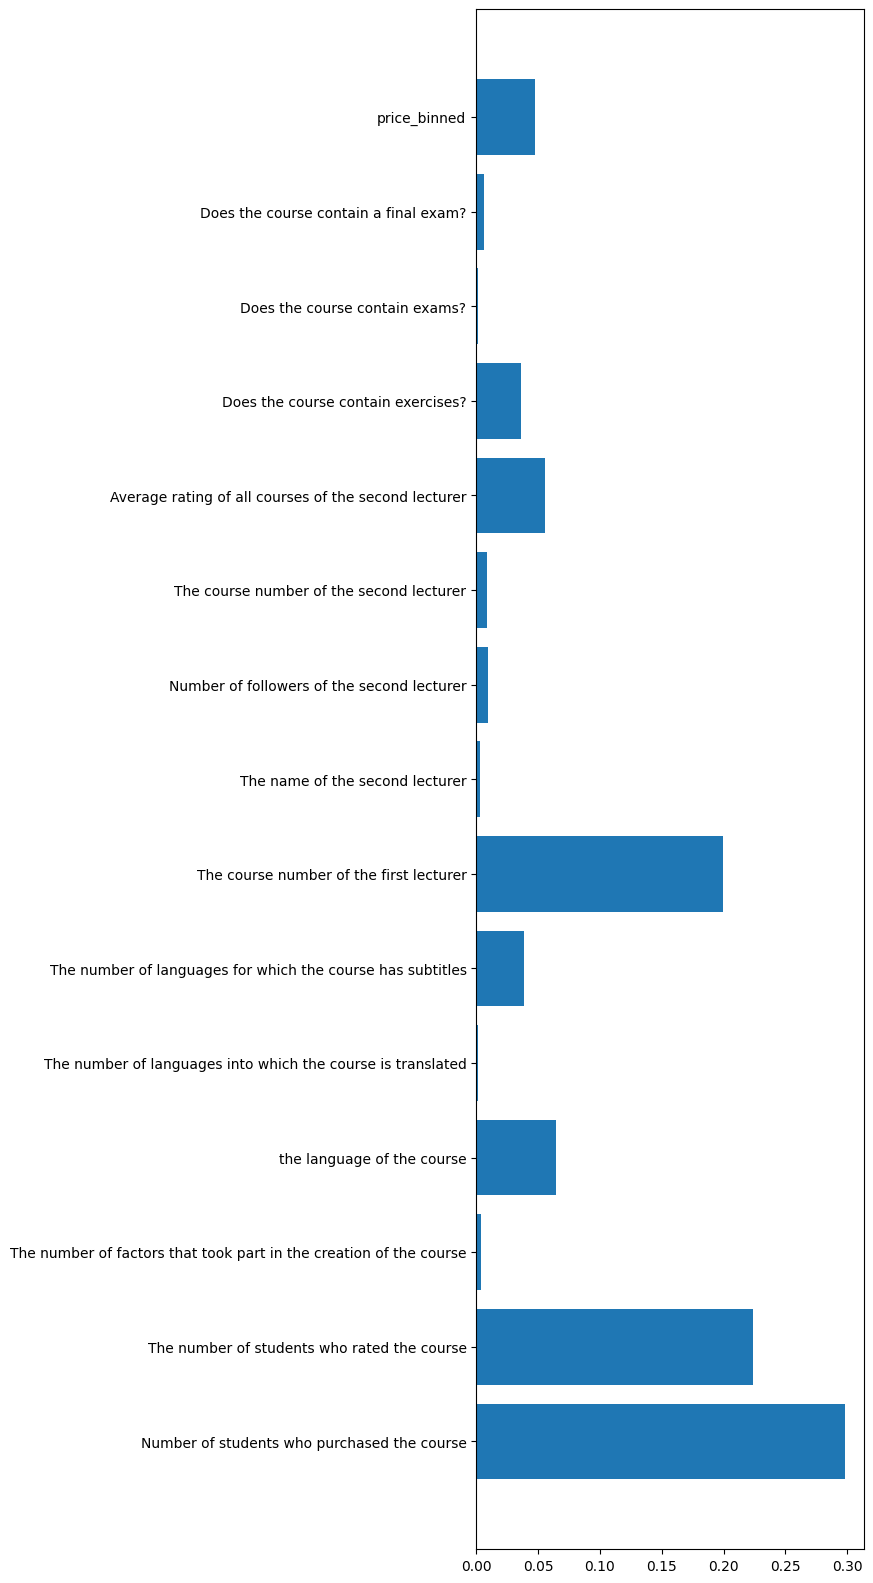

In [56]:
fig, ax = plt.subplots(figsize=(5,20))
plt.barh(X.columns, model.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

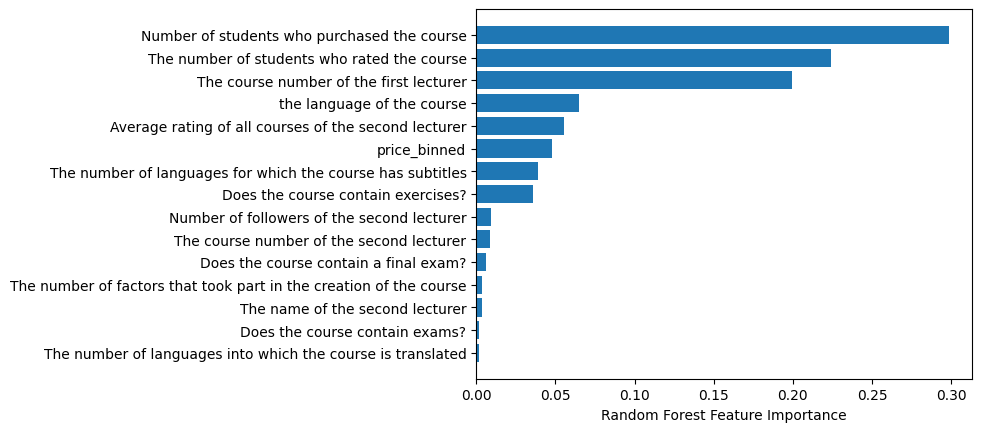

In [60]:
sorted_idx = model.feature_importances_.argsort(axis=-1)
plt.barh(X.columns[sorted_idx,], model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")